<a href="https://colab.research.google.com/github/mar-roige/GIS-course/blob/master/6_pysal_weights_moran_lisaMAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we're going to get into some key spatial statistics. So far in this course we've mostly been visualizing spatial distributions and patterns. Here we will run statistical tests to determine whether nor not a pattern or spatial structure exists, and to test what kind of pattern (dispersed vs. random vs. clustered) is present.

As usual, start by getting your tools. Remember that broken thing two weeks ago? Yep, still broken... hence the long list of imported libraries.


In [0]:
# start by installing tools as usual
!pip install geopandas
!pip install descartes
!pip install mapclassify
!pip install pysal

#@title
!apt-get install -qq curl g++ make
#@title
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
#@title
import os
os.chdir('spatialindex-src-1.8.5')
#@title
!./configure
#@title
!make
#@title
!make install
#@title
!pip install rtree
#@title
!ldconfig
#Working through the example at http://toblerity.org/rtree/examples.html
#@title
from rtree import index
from rtree.index import Rtree
#@title
p = index.Property()
idx = index.Index(properties=p)
idx

     |████████████████████████████████| 921kB 2.7MB/s 
     |████████████████████████████████| 10.1MB 44.8MB/s 
     |████████████████████████████████| 11.8MB 201kB/s 
  Created wheel for mapclassify: filename=mapclassify-2.1.1-cp36-none-any.whl size=29001 sha256=a0bfb10525efcfb21c86d43bb4d15b4394c8d28968bfdaaed12cef22efd9895a
  Stored in directory: /root/.cache/pip/wheels/fc/b8/58/56b650743289cbecb476ef1fc50ab0aeaa0b12e56ad912d624
Successfully built mapclassify
     |████████████████████████████████| 25.0MB 94kB/s 
  Created wheel for pysal: filename=pysal-2.1.0-py2.py3-none-any.whl size=25330028 sha256=f57254401117e7a0d8e2de125384f2c263c3fe91312a38a6d34b2d87bc15ee5d
  Stored in directory: /root/.cache/pip/wheels/d3/83/3d/697615f4ce74486679f237d1d6a1cf70cd742fa6a34baba744
Successfully built pysal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0  

In [0]:
#and importing tools...
import geopandas as gpd
import requests
import zipfile
import io
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import numpy as np


/usr/local/lib/python3.6/dist-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [0]:
# And now, as usual, get the data
url = 'https://github.com/ropitz/spatialarchaeology/blob/master/gabii_spatial.zip?raw=true'
local_path = 'temp/'

print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")

z.extractall(path=local_path) # extract to folder

filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)
dbf, shp, shx = [filename for filename in filenames]
gabii = gpd.read_file(local_path + 'gabii_SU_poly.shp')

Done
['gabii_SU_poly.dbf', 'gabii_SU_poly.shp', 'gabii_SU_poly.shx']


In [0]:
# As you've done before, print out some information on the data to check it has loaded in ok
print("Shape of the dataframe: {}".format(gabii.shape))
print("Projection of dataframe: {}".format(gabii.crs))
gabii.tail() #last 5 records in dataframe

Shape of the dataframe: (6774, 11)
Projection of dataframe: {}


,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry
6769,BOT,{71AF9B12-2F06-495C-83E5-0FAA360F8F4A},0.0,None,None,7258,0,0,2.678564,0.499149,"POLYGON Z ((2330859.598 4639809.998 58.475, 23..."
6770,PV,{0ACC8266-B607-4C90-80BC-CAA66B641158},0.0,basalt pavement,None,7259,0,0,1.884223,-0.011060,"POLYGON Z ((2330859.928 4639810.684 59.054, 23..."
6771,PV,{04AAFA17-1C2C-48DC-8D98-3F159C9594ED},0.0,road preparation,None,7260,0,0,4.340378,-0.315862,"POLYGON Z ((2330859.690 4639810.676 59.299, 23..."
6772,DEP,{29409DA1-5E72-4C40-B9EB-DF30BDA4AB99},0.0,surface,None,7244,0,0,3.931959,0.684395,"POLYGON Z ((2330858.600 4639808.870 59.492, 23..."
6773,FEAT,{800479EB-554B-4180-85C5-91DA0FE8C762},0.0,bedrock,None,7255,0,0,3.960617,-0.958252,"POLYGON Z ((2330859.137 4639808.867 58.846, 23..."


In [0]:
# As we've done before (returning to the Gabii finds data) get the non-spatial special finds data
sf_su = pd.read_csv("https://raw.githubusercontent.com/ropitz/gabii_experiments/master/spf_SU.csv")
sf_su.head()

,SU,SF_ID,SF_DESCRIPTION,SF_OBJECT_TYPE
0,0,1,coin,Coin
1,0,15,coin,Coin
2,0,18,coin,Coin
3,0,80,ceramic fragment,Ceramic Fragment
4,0,82,fish hook,NaN


In [0]:
#Then let's combine our polygons representing context shape and location
#with the special finds data
# We do this with a command called 'merge'

gabii_textools = gabii.merge(sf_su, on='SU')
gabii_textools.head()

,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry,SF_ID,SF_DESCRIPTION,SF_OBJECT_TYPE
0,DEP,{7547F186-D2C4-421D-A91C-330DE54C991A},0.0,None,None,1376,0,0,4.234191,0.867656,"POLYGON Z ((2330811.445 4639824.504 62.386, 23...",297,ring,Ring
1,DEP,{7547F186-D2C4-421D-A91C-330DE54C991A},0.0,None,None,1376,0,0,4.234191,0.867656,"POLYGON Z ((2330811.445 4639824.504 62.386, 23...",305,nail,NaN
2,DEP,{9749D670-DB74-425F-A059-9AA7C4DDB408},0.0,None,None,1375,0,0,4.282142,0.886152,"POLYGON Z ((2330811.441 4639824.495 62.385, 23...",300,stamp,NaN
3,DEP,{9749D670-DB74-425F-A059-9AA7C4DDB408},0.0,None,None,1375,0,0,4.282142,0.886152,"POLYGON Z ((2330811.441 4639824.495 62.385, 23...",398,stamp,NaN
4,DEP,{33BC7316-B87A-4FAD-B117-043B1B72927E},0.0,None,None,2258,0,0,33.824963,42.657425,"POLYGON Z ((2330865.519 4639860.941 61.348, 23...",320,Bone knob head hairpin,Pin


In [0]:
#Let's pull all those find types out of the big list. These commands should look familiar because you've done them before.
types = ['Loom Weight','Spool','Spindle Whorl']
textile_tools = gabii_textools.loc[gabii_textools['SF_OBJECT_TYPE'].isin(types)]

# Now let's count up how many of these tools appear in each context (SU).
# This command will print out a list of the number of textile tools in each SU next to that SU number.
textile_tool_counts = textile_tools.groupby('SU')['SF_OBJECT_TYPE'].value_counts().unstack().fillna(0)


gts = gabii_textools.merge(textile_tool_counts, on='SU')
gts_new = gts.drop_duplicates(subset="SU")
gts_new.head()

,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry,SF_ID,SF_DESCRIPTION,SF_OBJECT_TYPE,Loom Weight,Spindle Whorl,Spool
0,DEP,{33BC7316-B87A-4FAD-B117-043B1B72927E},0.0,None,None,2258,0,0,33.824963,42.657425,"POLYGON Z ((2330865.519 4639860.941 61.348, 23...",320,Bone knob head hairpin,Pin,0.0,0.0,1.0
4,DEP,{9322E5A4-3B71-4E18-A8D3-61067000D37A},0.0,survey innacuracy circa 4cm,None,516,0,0,29.108417,24.196861,"POLYGON Z ((2330791.518 4639855.147 64.693, 23...",261,spool,Spool,1.0,0.0,1.0
6,DEP,{14B94C91-950D-4F3F-8CB0-A3D3CF196FCE},0.0,None,None,587,0,0,31.845889,35.011648,"POLYGON Z ((2330786.540 4639851.471 64.633, 23...",262,loom weight,Loom Weight,1.0,0.0,0.0
8,DEP,{34DFB891-ECF7-477A-939D-87491FA05165},0.0,None,None,1306,0,0,26.189290,11.969015,"POLYGON Z ((2330807.058 4639840.405 63.413, 23...",281,complete vessel,Votive,0.0,0.0,1.0
11,DEP,{9CBC09F7-DBBF-4F8E-A6F9-278240E34672},0.0,None,None,1327,0,0,39.322690,67.846039,"POLYGON Z ((2330807.254 4639825.210 63.122, 23...",287,gaming piece - die,Game Piece,1.0,0.0,0.0


Now plot your data to visualize it.

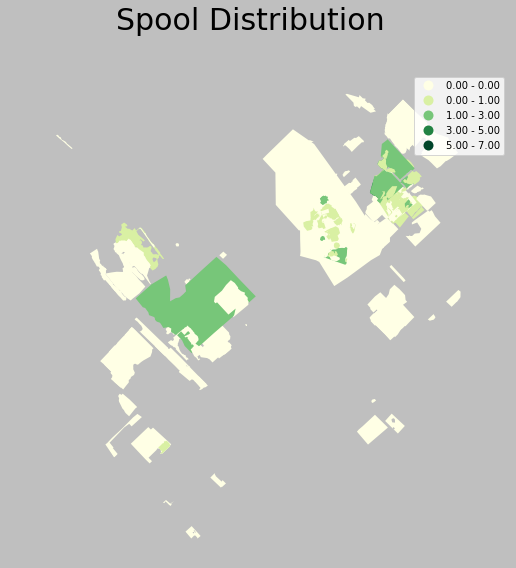

In [0]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot SUs
#gabii.plot(ax=ax, facecolor='0.85', linewidth=0)
# Quantile choropleth of deaths at the street level
gts_new.plot(column='Spool', scheme='fisher_jenks', ax=ax, \
        cmap='YlGn', legend=True, linewidth=3)
# Plot pumps
#xys = np.array([(pt.x, pt.y) for pt in pumps.geometry])
#ax.scatter(xys[:, 0], xys[:, 1], marker='^', color='k', s=50)
# Remove axis frame
ax.set_axis_off()
# Change background color of the figure
f.set_facecolor('0.75')
# Keep axes proportionate
plt.axis('equal')
# Title
f.suptitle('Spool Distribution', size=30)
# Draw
plt.show()

So far you've (rapidly) repeated the steps you've done in a previous exercise to visualize a spatial pattern - this time of the spools discovered while excavating at Gabii. 

Now how do you statistically test if there is a pattern? Because it's not so obvious from just looking at the distribution. We can start with some of the more basic tests: Moran's and local Moran's, which are tests for spatial autocorrelation. 

Read about [Moran's](https://mgimond.github.io/Spatial/spatial-autocorrelation.html)


In [0]:
# To start your Moran's statistical test, you need to create weights that define how strongly you think things near to one another influence one another.
# see the types of weights available to you by looking in pysals help file
help(ps.lib.weights)

Help on package pysal.lib.weights in pysal.lib:

NAME
    pysal.lib.weights

PACKAGE CONTENTS
    _contW_lists
    adjtools
    contiguity
    distance
    set_operations
    spatial_lag
    spintW
    tests (package)
    user
    util
    weights

FILE
    /usr/local/lib/python3.6/dist-packages/pysal/lib/weights/__init__.py




In [0]:
#create sme weights. I've gone with KNN weights. Ignore the warnings, we know not all the SU areas connect up physically
gts_spool = gts_new[['SU','Spool']]
gts_spool_weights = ps.lib.weights.KNN(gts_spool,5)

/usr/local/lib/python3.6/dist-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 9 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [0]:
# Rename IDs to match those in the `segIdStr` column
gts_spool_weights.remap_ids(gts_spool.index)
# Row standardize the matrix
gts_spool_weights.transform = 'R'

In [0]:
#add the weights you've created to the attribute table
gts_spool['gts_spool_weights'] = ps.lib.weights.lag_spatial(gts_spool_weights, gts_spool['Spool'])
gts_spool.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SU,Spool,gts_spool_weights
0,2258,1.0,0.8
4,516,1.0,0.2
6,587,0.0,0.2
8,1306,1.0,0.2
11,1327,0.0,0.4


Now we want to standardize our counts.

Read about [standardization](http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-statistics-toolbox/modeling-spatial-relationships.htm#GUID-DB9C20A7-51DB-4704-A0D7-1D4EA22C23A7) in spatial modelling to see why.

In [0]:
# standardize the counts of the number of spools in each context and the weights
gts_spool['spool_std'] = (gts_spool['Spool'] - gts_spool['Spool'].mean()) / gts_spool['Spool'].std()
gts_spool['w_spool_std'] = ps.lib.weights.lag_spatial(gts_spool_weights, gts_spool['spool_std'])
gts_spool.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SU,Spool,gts_spool_weights,spool_std,w_spool_std
0,2258,1.0,0.8,0.277424,0.101860
4,516,1.0,0.2,0.277424,-0.424831
6,587,0.0,0.2,-0.600394,-0.424831
8,1306,1.0,0.2,0.277424,-0.424831
11,1327,0.0,0.4,-0.600394,-0.249267


In [0]:
#get some more tools for the Moran test
from pysal.explore.esda.moran import Moran

In [0]:
# Run the Moran test
mi = Moran(gts_spool['Spool'], gts_spool_weights)
mi.I


0.14024220082341388

What does the value above mean?
Read how to [interpret the results](https://www.statisticshowto.datasciencecentral.com/morans-i/).

Are your spools actually clustered?

Now plot the results.

The cluster/outlier type (COType) field distinguishes between a statistically significant cluster of high values (HH), cluster of low values (LL), outlier in which a high value is surrounded primarily by low values (HL), and outlier in which a low value is surrounded primarily by high values (LH). Statistical significance is set at the 95 percent confidence level. 

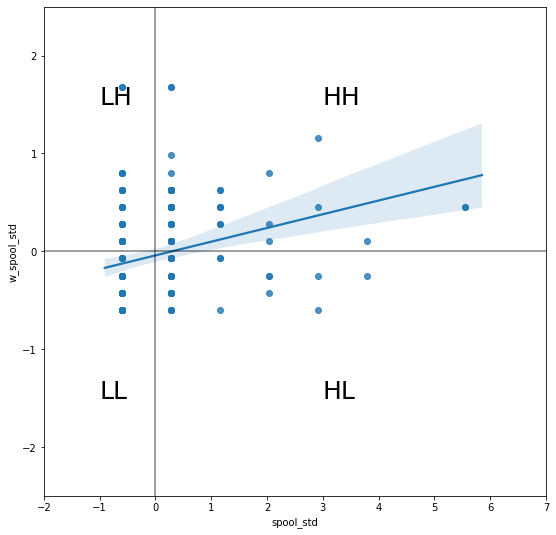

In [0]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='spool_std', y='w_spool_std', data=gts_spool)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-2, 7)
ax.set_ylim(-2.5, 2.5)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)
# Display
plt.show()

We started by looking at the global pattern - that is the overall pattern. But might there be local patterns inside the global one? To test this, we use the local variant of the Moran's test.

In [0]:
# get the tools for the local test
from pysal.explore.esda.moran import Moran_Local

In [0]:
# run the local test
lisa = Moran_Local(gts_spool['Spool'].values, gts_spool_weights)

The local test breaks the global pattern down to test for the presence of local clusters. You can check at each SU whether or not it is likely (in a statistical significance sense) for it to participate in a local cluster.

A positive value for I indicates that a feature has neighboring features with similarly high or low attribute values; this feature is part of a cluster. A negative value for I indicates that a feature has neighboring features with dissimilar values; this feature is an outlier. In either instance, the p-value for the feature must be small enough for the cluster or outlier to be considered statistically significant. Note that the local Moran's I index (I) is a relative measure and can only be interpreted within the context of its computed z-score or p-value.

In [0]:
# Break observations into significant or not
gts_spool['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to - the high-high, high-low, low-high, low-low from before are quads 1-4
gts_spool['quadrant'] = lisa.q
gts_spool['significant'][:20]
# true means it is in a cluster, false means it is not

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0     False
4     False
6      True
8     False
11    False
20    False
36    False
37    False
38    False
39     True
41    False
42    False
44    False
47     True
48     True
60     True
61    False
64    False
66     True
67    False
Name: significant, dtype: bool

In [0]:
# You can read out the calculated p values for each 
lisa.p_sim[:20]

array([0.37 , 0.069, 0.049, 0.057, 0.342, 0.07 , 0.055, 0.354, 0.058,
       0.001, 0.375, 0.348, 0.281, 0.001, 0.001, 0.001, 0.338, 0.263,
       0.001, 0.058])

In [0]:
#add this info back onto the spatial data
gabii_spool_lisa = gabii.merge(gts_spool, on='SU')
gabii_spool_lisa.head()

,DESCRIPTIO,GlobalID,tomb_ID,notes,Room_ID,SU,Excavated,Top_of_Wal,SHAPE_Leng,SHAPE_Area,geometry,Spool,gts_spool_weights,spool_std,w_spool_std,significant,quadrant
0,DEP,{33BC7316-B87A-4FAD-B117-043B1B72927E},0.0,None,None,2258,0,0,33.824963,42.657425,"POLYGON Z ((2330865.519 4639860.941 61.348, 23...",1.0,0.8,0.277424,0.101860,False,1
1,DEP,{9322E5A4-3B71-4E18-A8D3-61067000D37A},0.0,survey innacuracy circa 4cm,None,516,0,0,29.108417,24.196861,"POLYGON Z ((2330791.518 4639855.147 64.693, 23...",1.0,0.2,0.277424,-0.424831,False,4
2,DEP,{14B94C91-950D-4F3F-8CB0-A3D3CF196FCE},0.0,None,None,587,0,0,31.845889,35.011648,"POLYGON Z ((2330786.540 4639851.471 64.633, 23...",0.0,0.2,-0.600394,-0.424831,True,3
3,DEP,{34DFB891-ECF7-477A-939D-87491FA05165},0.0,None,None,1306,0,0,26.189290,11.969015,"POLYGON Z ((2330807.058 4639840.405 63.413, 23...",1.0,0.2,0.277424,-0.424831,False,4
4,DEP,{9CBC09F7-DBBF-4F8E-A6F9-278240E34672},0.0,None,None,1327,0,0,39.322690,67.846039,"POLYGON Z ((2330807.254 4639825.210 63.122, 23...",0.0,0.4,-0.600394,-0.249267,False,3


Now we can make a map showing which quadrant each SU belongs to, essentially a display of where the local clusters are located.

High-high = 4
Low-low = 2

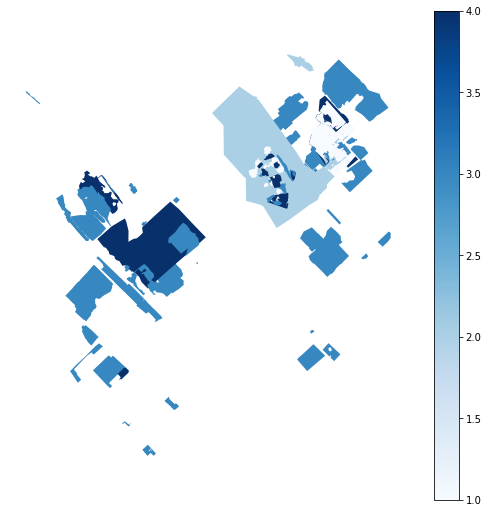

In [0]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot baseline su poly
gabii_spool_lisa.plot(column='quadrant',  ax=ax, \
        cmap='Blues', legend=True, linewidth=3)

ax.set_axis_off()
plt.axis('equal')
plt.show()

How would you interpret the results of this analysis?

## From Vector to Raster

You can run similar spatial statistics on raster data to understand trends and distributions of data. It is possible to convert from point vector data to raster data via the process of [interpolation](https://www.neonscience.org/spatial-interpolation-basics). There are many ways to interpolate data, which you can read about on the linked site.

##Whitebox is an open source GIS. 
It's full of hundreds of useful spatial tools. You can download it and run it standalone (without installing!) or you can call its functions from the jupyter notebook. It will be well worth checking out for your own independent projects.

Read about [Whitebox Tools](https://github.com/jblindsay/whitebox-tools)

In [0]:
# we're going to use the whitebox tools to interpolate our data and imageio to view it
!pip install whitebox
!pip install imageio
!pip install imageio tifffile

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [0]:
# import your tools and print the version to check it worked

import pkg_resources
import whitebox
import imageio
import IPython # for displaying html outputs

wbt = whitebox.WhiteboxTools()
print(wbt.version())
print(wbt.help())

WhiteboxTools v1.0.2 by Dr. John B. Lindsay (c) 2017-2019

WhiteboxTools is an advanced geospatial data analysis platform developed at
the University of Guelph's Geomorphometry and Hydrogeomatics Research 
Group (GHRG). See https://jblindsay.github.io/ghrg/WhiteboxTools/index.html
for more details.

WhiteboxTools Help

The following commands are recognized:
--cd, --wd       Changes the working directory; used in conjunction with --run flag.
-h, --help       Prints help information.
-l, --license    Prints the whitebox-tools license.
--listtools      Lists all available tools. Keywords may also be used, --listtools slope.
-r, --run        Runs a tool; used in conjuction with --wd flag; -r="LidarInfo".
--toolbox        Prints the toolbox associated with a tool; --toolbox=Slope.
--toolhelp       Prints the help associated with a tool; --toolhelp="LidarInfo".
--toolparameters Prints the parameters (in json form) for a specific tool; --toolparameters="LidarInfo".
-v               Verbose mo

In [0]:
# when there are lots of tools, it's useful to call their help info to find out what the parameters are
print(wbt.tool_help("IdwInterpolation"))

IdwInterpolation
Description:
Interpolates vector points into a raster surface using an inverse-distance weighted scheme.
Toolbox: GIS Analysis
Parameters:

Flag               Description
-----------------  -----------
-i, --input        Input vector Points file.
--field            Input field name in attribute table.
--use_z            Use z-coordinate instead of field?
-o, --output       Output raster file.
--weight           IDW weight value.
--radius           Search Radius.
--min_points       Minimum number of points.
--cell_size        Optionally specified cell size of output raster. Not used when base raster is specified.
--base             Optionally specified input base raster file. Not used when a cell size is specified.


Example usage:
>>./whitebox_tools -r=IdwInterpolation -v --wd="/path/to/data/" -i=points.shp --field=ELEV -o=output.tif --weight=2.0 --radius=4.0 --min_points=3 --cell_size=1.0
>>./whitebox_tools -r=IdwInterpolation -v --wd="/path/to/data/" -i=points.shp --

In [0]:
# To interpolate, as you may have noticed in your reading, we need points rather than polygons. To have points we get the center of each polygon. 
# In these lines we essentially strip out the geometry information when we get the center of each polygon. Then we 'merge' to glue the attribute we are interested in interpolating back on to our data.

spool_centroids = gabii_spool_lisa.geometry.centroid
spoolgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(spool_centroids))
spool_centroids_attr = spoolgdf.merge(gabii_spool_lisa.spool_std,right_index=True,left_index=True)

In [0]:
# to work in whitebox effectively, we put this data out to a temporary shapefile
# we also set a data directory where we can put this file
wbt.set_working_dir(data_dir)
print(data_dir)
wbt.verbose = True
gabii_spool_shapes = spool_centroids_attr.to_file("/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.shp")

./whitebox_tools --run="IdwInterpolation" --input='gabii_spool.shp' --field='spool_std' --output='gabii_spool.tif' --weight=2.0 --radius='5' --min_points='3' --cell_size='1' -v

*******************************
* Welcome to IdwInterpolation *
*******************************
Reading data...
thread 'main' panicked at 'called `Result::unwrap()` on an `Err` value: Os { code: 2, kind: NotFound, message: "No such file or directory" }', src/libcore/result.rs:1084:5
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace.


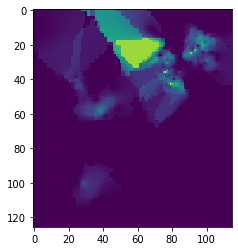

In [0]:
# now we interpolate our centriods using the standardized spool weights and show the result
# note you can play around with the interpolation parameters to have different kernal sizes and cell sizes...
wbt.idw_interpolation(
    i="gabii_spool.shp", 
    field="spool_std",
    output="gabii_spool.tif", 
    use_z=False, 
    weight=2.0, 
    radius=5, 
    min_points=3, 
    cell_size=1, 
    base=None
)
raster = imageio.imread(os.path.join(data_dir, 'gabii_spool.tif'))
plt.imshow(raster)
plt.show()

Now you can calculate statistics on this dataset, for example using rasterio like we did last week, or using whitebox's tools.

For example, you can check to see if the data forms a normal distribution. 
This lets you know what kinds of statistical tests will be valid. As we discussed last week, often archaeological distributions are not normal.


In [0]:
wbt.ks_test_for_normality(
    "/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif", 
    "normal", 
    num_samples=None
)

./whitebox_tools --run="KsTestForNormality" --input='/usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif' --output='normal' -v

*********************************
* Welcome to KsTestForNormality *
*********************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 44%
Progress: 45%
Progress: 46%
Progress: 47%
Progress: 48%
Progress: 49%
Progress: 50%
Progress: 51%
Progress: 52%
Progress: 53%
Pro

0

In [0]:
# view your results
IPython.display.HTML(filename='/normal.html')

You can also run a similar autocorrelation test to the LISA one we ran above with the vector data.

In [0]:
wbt.image_autocorrelation(
    " /usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif", 
    "gabii_autocorr.html", 
    contiguity="Rook"
)

./whitebox_tools --run="ImageAutocorrelation" --inputs=' /usr/local/lib/python3.6/dist-packages/whitebox/testdata/gabii_spool.tif' --contiguity=Rook --output='gabii_autocorr.html' -v

***********************************
* Welcome to ImageAutocorrelation *
***********************************
Calculating image averages...
Progress (Loop 1 of 2): 0%
Progress (Loop 1 of 2): 100%
Progress (Loop 2 of 2): 0%
Progress (Loop 2 of 2): 1%
Progress (Loop 2 of 2): 2%
Progress (Loop 2 of 2): 3%
Progress (Loop 2 of 2): 4%
Progress (Loop 2 of 2): 5%
Progress (Loop 2 of 2): 6%
Progress (Loop 2 of 2): 7%
Progress (Loop 2 of 2): 8%
Progress (Loop 2 of 2): 9%
Progress (Loop 2 of 2): 10%
Progress (Loop 2 of 2): 11%
Progress (Loop 2 of 2): 12%
Progress (Loop 2 of 2): 13%
Progress (Loop 2 of 2): 14%
Progress (Loop 2 of 2): 15%
Progress (Loop 2 of 2): 16%
Progress (Loop 2 of 2): 17%
Progress (Loop 2 of 2): 18%
Progress (Loop 2 of 2): 19%
Progress (Loop 2 of 2): 20%
Progress (Loop 2 of 2): 21%
Progress (Loop 2

0

In [0]:
# view your results
IPython.display.HTML(filename='/gabii_autocorr.html')

This exercise ends here. Hopefully you've learned that there are statistical tests for spatial patterns and that these let us go beyond 'just visualizing' to look for patterns. These tests can be run on either vector or raster data.

Clearly there's a lot to learn and explore in the world of spatial stats...